
# Individual Assignment I: Machine Learning Foundation
**Data Preparation**

GitHub Repository: [https://github.com/christophrrrrr/ML-fundamentals-2026](https://github.com/christophrrrrr/ML-fundamentals-2026)


This notebook executes data preparation and feature engineering tasks for the UCI Bank Marketing Dataset (`bank-additional.csv`), adhering to data leakage prevention principles.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler



## 1. Identifying the Prediction Target

*Lecture material: Lecture 1 (Problem Formulation), Lecture 2 (Data Inspection).*

**Target Selection:**
The target variable is `y`. `y` records `"yes"` or `"no"` indicating whether the client subscribed to a term deposit. This aligns with the stated objective of the direct marketing campaigns.

**Invalid Alternatives:**
Three other variables might appear to be valid targets but must not be used:
1. `duration`: This represents the call duration in seconds. While highly correlated with `y`, it is an outcome of the call. At prediction time (before or during the start of the call), this information is unavailable. Predicting `duration` does not address the business goal of identifying who will subscribe. Including it results in data leakage.
2. `poutcome`: Records the result of the previous marketing campaign. The prediction objective defined for this assignment is whether the client subscribes in the current campaign. `poutcome` describes an event that has already occurred and is available as an input at prediction time — it is an input feature, not the target. Using it as a prediction target would mean predicting something already known, which has no operational value.
3. `campaign`: Records the number of contacts performed during the current campaign. One might argue this represents campaign effort worth predicting or optimizing. However, `campaign` is a campaign execution variable accumulated during the contact process — it is not the business outcome. The goal is predicting client behavior (`y`), not the number of calls made. It is also partially available at prediction time (current call count), making its use as a target conceptually incoherent.



## 2. Data Loading and Exploration

*Lecture material: Lecture 1 (Problem Formulation), Lecture 2 (Data Inspection and EDA).*

- `bank-additional.csv` is the 10% sample (4119 rows) randomly selected from `bank-additional-full.csv` (41188 rows).
- We prefer the full dataset but fall back to the 10% sample to keep computation light or if the full set is unavailable. The preprocessing pipeline remains structurally identical regardless.
Note that UCI bank datasets commonly use the semicolon `;` separator.


In [2]:

# Load dataset
import os

full_filepath = 'data/bank-additional-full.csv'
sample_filepath = 'data/bank-additional.csv'
github_sample_url = 'https://raw.githubusercontent.com/christophrrrrr/ML-fundamentals-2026/main/data/bank-additional.csv'

# Attempt to load full dataset first, then fall back to sample, then to remote link
if os.path.exists(full_filepath):
    print(f"Loading full dataset from: {full_filepath}")
    df = pd.read_csv(full_filepath, sep=';')
elif os.path.exists(sample_filepath):
    print(f"Loading 10% sample dataset from: {sample_filepath}")
    df = pd.read_csv(sample_filepath, sep=';')
else:
    print(f"Local instance not found. Downloading 10% sample directly from GitHub repository...")
    df = pd.read_csv(github_sample_url, sep=';')

# Basic structure
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Summary Statistics ---")
display(df.describe())


Local instance not found. Downloading 10% sample directly from GitHub repository...
Number of observations: 4119
Number of features: 21

--- Data Types ---
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

--- Summary Statistics ---


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000



**Variable Identification (raw dataset, prior to feature engineering):**
- **Numerical:** `age`, `duration`, `campaign`, `pdays`, `previous`,
  `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`,
  `nr.employed`
- **Categorical:** `job`, `marital`, `education`, `default`, `housing`,
  `loan`, `contact`, `month`, `day_of_week`, `poutcome`, `y`

Note: `duration` is identified here for completeness but is dropped
immediately in the next section due to target leakage. `pdays` is
replaced by two engineered features (`prev_contacted`, `pdays_clean`)
that separate its binary and continuous information.


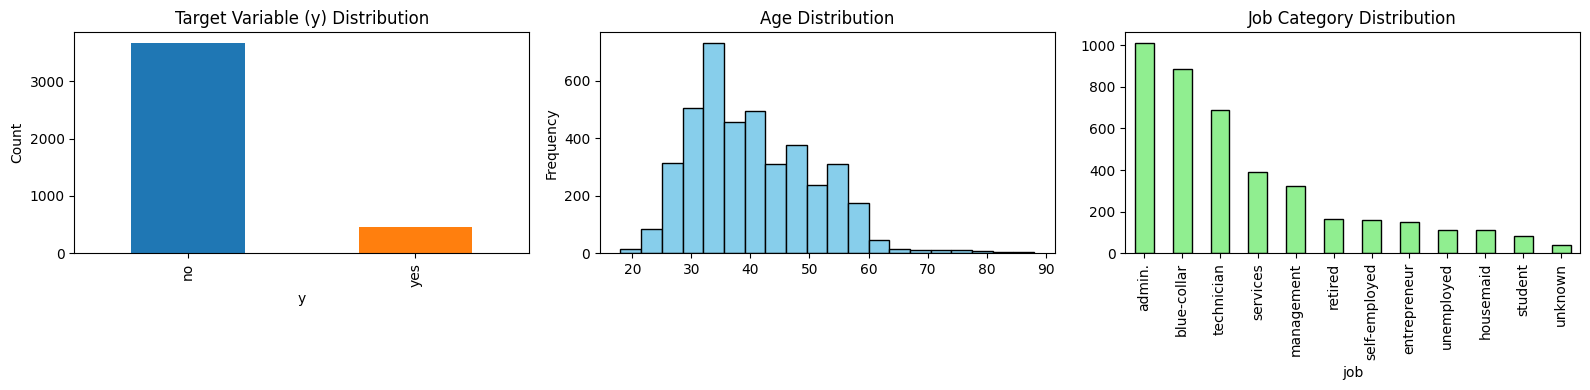

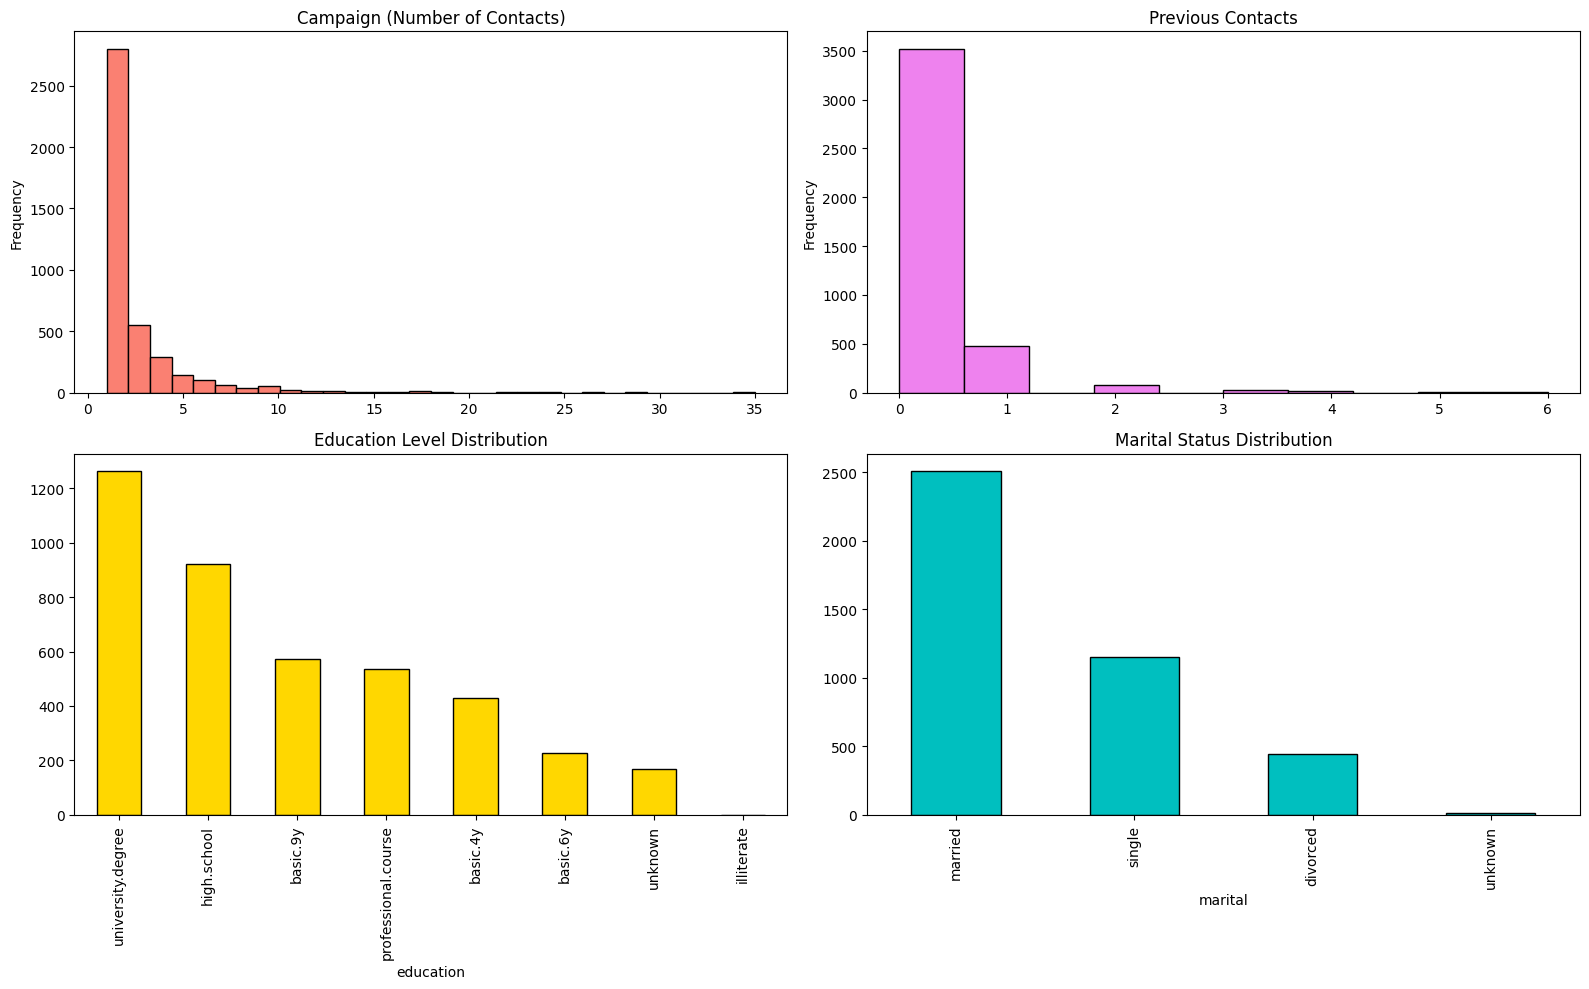

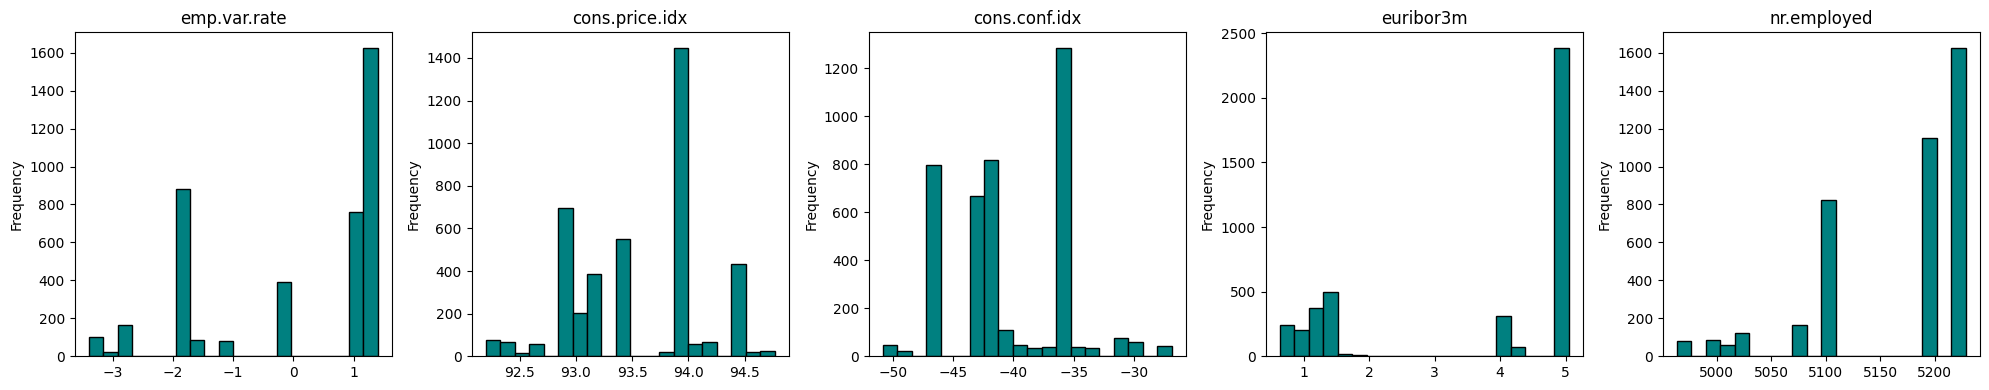

Target variable counts:
y
no     3668
yes     451
Name: count, dtype: int64

Target variable percentages:
y
no     0.890507
yes    0.109493
Name: proportion, dtype: float64


In [3]:

# Target Distribution
y_counts = df['y'].value_counts()
y_pct = df['y'].value_counts(normalize=True)

# --- Figure 1: Target, Age, Job ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
df['y'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=axes[0])
axes[0].set_title('Target Variable (y) Distribution')
axes[0].set_ylabel('Count')

df['age'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Age Distribution')

df['job'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black', ax=axes[2])
axes[2].set_title('Job Category Distribution')
plt.tight_layout()
plt.show()

# --- Figure 2: Campaign, Previous, Education, Marital ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))

df['campaign'].plot(kind='hist', bins=30, color='salmon', edgecolor='black', ax=axes2[0, 0])
axes2[0, 0].set_title('Campaign (Number of Contacts)')

df['previous'].plot(kind='hist', bins=10, color='violet', edgecolor='black', ax=axes2[0, 1])
axes2[0, 1].set_title('Previous Contacts')

df['education'].value_counts().plot(kind='bar', color='gold', edgecolor='black', ax=axes2[1, 0])
axes2[1, 0].set_title('Education Level Distribution')

df['marital'].value_counts().plot(kind='bar', color='c', edgecolor='black', ax=axes2[1, 1])
axes2[1, 1].set_title('Marital Status Distribution')

plt.tight_layout()
plt.show()

# --- Figure 3: Macroeconomic Variables ---
macro_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
fig3, axes3 = plt.subplots(1, 5, figsize=(20, 4))
for i, var in enumerate(macro_vars):
    df[var].plot(kind='hist', bins=20, color='teal', edgecolor='black', ax=axes3[i])
    axes3[i].set_title(var)
plt.tight_layout()
plt.show()

print("Target variable counts:")
print(y_counts)
print("\nTarget variable percentages:")
print(y_pct)



**General Observations:**
- **Class Imbalance:** Only ~10.9% of clients subscribed (`yes`). Class imbalance handling is required to prevent the model from trivializing predictions.
- **Skewed Variables:** `campaign` is right-skewed (most clients are contacted 1–3 times, with a long tail reaching 35). `previous` is zero for the majority of clients. A log transform of `campaign` was considered to reduce the influence of outliers on the linear model's coefficient estimation. It was ultimately not applied here to keep the pipeline interpretable and because StandardScaler will centre and scale the variable regardless — but this remains a worthwhile preprocessing step to explore.
- **Category Ratios:** `university.degree` and `high.school` represent the most frequent `education` levels. The majority of clients are married.
- **Target Leakage Variable:** `duration` is only known after the call finishes. It must be dropped.
- **Implicit Missing Values:** Categorical variables utilize `"unknown"` as an implicit missing value. `pdays` uses `999` to indicate "never contacted before".



**Macroeconomic Observations:**
- `euribor3m` and `nr.employed` show bimodal distributions, clustering into two distinct regimes that likely correspond to pre- and post-2008 economic periods in the dataset.
- `emp.var.rate` is similarly clustered rather than continuous, reinforcing that macroeconomic features track the same underlying economic cycle.
- These distributions suggest the macroeconomic block may carry redundant information — addressed formally in Feature Selection.



## 3. Task Ordering

*Lecture material: Lecture 2 (Data Splitting and Leakage), Lecture 5 (Preprocessing), Lecture 9 (ML Pipeline).*

To prevent data leakage, data preparation tasks are executed in the following sequence:

1. **Identifying Target & Data Loading** (Completed above)
    - Allowed: Raw dataset viewing, broad target assessment.
    - Not allowed: Predicting on or analyzing combinations of target vs features globally.
    - Leakage risk if changed: None at this stage, assuming `duration` is dropped manually before modeling metrics run.
2. **Managing Missing Values (Identification & Structural Cleaning)**
    - Allowed: Finding distinct string literals (e.g. `"unknown"`) or sentinel values (`999`) and structurally replacing them with `NaN` or indicator flags.
    - Not allowed: Computing median, mean, or mode across the column to fill the `NaN` values.
    - Leakage risk if changed: Replacing `"unknown"` specifically does not use global distribution data. However, if statistical imputation were performed here instead, it would leak test-set central tendencies into the training data.
3. **Data Splitting**
    - Allowed: Raw input variables (`X`) and targets (`y`).
    - Not allowed: Any fitted statistical boundaries, encodings, or synthetic samples.
    - Leakage risk if changed: If delayed, transformation steps would consume information belonging to the test set, compromising final evaluation integrity.
4. **Managing Missing Values (Statistical Imputation)**
    - Allowed: Medians/Modes calculated from `X_train`.
    - Not allowed: Test set distribution properties.
    - Leakage risk if changed: If placed before Data Splitting, the median would include test observations.
5. **Encoding Categorical Variables**
    - Allowed: List of distinct categories present in `X_train`.
    - Not allowed: Categories that only exist in `X_test`.
    - Leakage risk if changed: The algorithm would map dummy dimensions for categories it has not seen yet.
6. **Feature Scaling**
    - Allowed: Compute mean and variance only over `X_train` via `.fit()`.
    - Not allowed: Running `.fit()` on `X_test`.
    - Leakage risk if changed: If placed before Data Splitting, the feature distances for the test set observations would be compressed based on training outliers.
7. **Feature Selection**
    - Allowed: Variance thresholds and correlation matrices computed over `X_train`.
    - Not allowed: Entire dataset correlations.
    - Leakage risk if changed: If executed upfront, variables would be deleted based on how they correlate with target labels inside the test set.
8. **Addressing Class Imbalance**
    - Allowed: Resampling methods (e.g. RandomOverSampler) applied within the training set.
    - Not allowed: Resampling before Data Splitting.
    - Leakage risk if changed: If RandomOverSampler generated synthetic samples before the train/test split, synthesized points mathematically linked to train observations would land in the test set.

**Incorrect Ordering Example (Scaling before Splitting):**
If Feature Scaling is performed before Data Splitting, the mean and standard deviation are calculated across the entire dataset. The standardized test values inherently contain information about the central tendency of the training set. This is data leakage.

**Incorrect Ordering Example 2 — Resampling before splitting:**
If RandomOverSampler were applied to the full dataset before the train/val/test split,
synthetic minority samples would be generated using the entire data
distribution. When the dataset is subsequently split, some synthetic
samples — constructed using observations that end up in the validation or
test sets — will appear in the training set. The model trains on data
derived from the test set. Validation and test metrics will be inflated
because the boundary between training and evaluation data has been
contaminated. The correct position for any resampling operation is after
splitting, applied to the training set only.



## 4. Managing Missing Values (Part 1: Identification & Sentinel Cleaning)

*Lecture material: Lecture 2 (Data Inspection), Lecture 5 (Preprocessing and Pipeline Discipline).*

**Identification:**
- Explicit missing values (`NaN`) are largely absent in this CSV.
- Implicit missing values are abundant. Words like `"unknown"` map strictly to missing information.
- In numerical columns, `pdays=999` acts as a sentinel for "client was not previously contacted".

We must convert these implicit symbols into standard structural missingness (`NaN`) before splitting, alongside creating feature flags.

*Note on Leakage:* Because we are just structurally replacing `"unknown" -> NaN` and extracting `pdays != 999`, we are not calculating statistics. Therefore, this is purely "data cleaning" and is safe to execute before Data Splitting.


In [4]:

# Drop 'duration' immediately to prevent leakage before any further inspection
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

# Count categorical 'unknown' and numerical '999' before cleaning
missing_counts = []

for col in df.drop(columns=['y']).select_dtypes(include=['object']).columns:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        missing_counts.append({
            'Variable': col,
            'Implicit Missing': unknown_count,
            '% of Total': f"{(unknown_count / len(df)) * 100:.2f}%"
        })

pdays_count = (df['pdays'] == 999).sum()
if pdays_count > 0:
    missing_counts.append({
        'Variable': 'pdays',
        'Implicit Missing': pdays_count,
        '% of Total': f"{(pdays_count / len(df)) * 100:.2f}%"
    })

missing_df = pd.DataFrame(missing_counts)
print("--- Implicit Missing Values Summary Before Structural Cleaning ---")
display(missing_df)


--- Implicit Missing Values Summary Before Structural Cleaning ---


,Variable,Implicit Missing,% of Total
0,job,39,0.95%
1,marital,11,0.27%
2,education,167,4.05%
3,default,803,19.50%
4,housing,105,2.55%
5,loan,105,2.55%
6,pdays,3959,96.12%


In [5]:

# 1. Handle Categorical 'unknown'
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].replace('unknown', np.nan)

# 2. Handle 'pdays' Sentinel
# Create a logical flag for previous contact
df['prev_contacted'] = (df['pdays'] != 999).astype(int)
# Clean the magnitude (so 999 doesn't distort linear models)
df['pdays_clean'] = df['pdays'].replace(999, np.nan)
df = df.drop(columns=['pdays'])

missing_summary = df.isna().sum()
print("Missing (NaN) counts after structured cleaning:")
print(missing_summary[missing_summary > 0])


Missing (NaN) counts after structured cleaning:
job              39
marital          11
education       167
default         803
housing         105
loan            105
pdays_clean    3959
dtype: int64



## 5. Data Splitting

*Lecture material: Lecture 2 (Data Splitting and Leakage), Lecture 9 (ML Pipeline).*

The independent features `X` and the target `y` are separated using a stratified split.

**Proportions:**
- Training: 70% (Used to learn parameters for imputation, scaling, encoding, and modeling).
- Validation: 15% (Used to evaluate model health during iterations and tune hyperparameters).
- Test: 15% (Held-out subset for final generalization reporting).

**Stratification:** `stratify=y` is used because the target is imbalanced (~11% positives). A random split could yield a training set with very few positive examples, leading to instability.

**Leakage Prevention:** Executing this split here ensures that upcoming steps (Scaling, Imputation, Encoding) can only `fit()` on mathematical properties present in `X_train`.


In [6]:

X = df.drop(columns=['y'])
y = df['y']

# First split: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Second split: Temp -> Validation (50% of 30% = 15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2883, 20)
X_val shape: (618, 20)
X_test shape: (618, 20)



## 6. Managing Missing Values (Part 2: Imputation)

The statistical modeling logic is established inside `scikit-learn` Pipelines.

- **Numerical Imputation (`pdays_clean`):** `pdays_clean` has 96% missing data. Because the variance of "was previously contacted vs wasn't" is captured using the binary `prev_contacted` flag, imputing `pdays_clean` with the Train median imputes a near-empty column with a static baseline. The variable is retained because the 4% of clients with previous campaigns possess numerical magnitudes that a linear model can use.
- **Categorical Imputation:** We replace categorical `NaN` with the explicit string `"missing"`. This records missingness directly as an additional feature state rather than discarding it.
- **Note on `default` (19.5% missing):** `default` records whether a client has credit in default — the highest missingness rate of any categorical variable. Dropping the column entirely was considered, but rejected: the 80.5% of non-missing values still carry signal, and the `"missing"` imputation strategy preserves the missingness pattern as its own category, which the model can learn from. If missingness on `default` is itself predictive of subscription behaviour (e.g. banks may withhold this information for certain client profiles), encoding it explicitly as `"missing"` captures that signal rather than discarding it.


In [7]:

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Define Imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# We hold off assembling the full ColumnTransformer until we define Scaling/Encoding.



## 7. Encoding Categorical Variables

*Lecture material: Lecture 4 (Categorical Encoding), Lecture 6 (Linear Models).*

**Classification:**
- **Nominal Variables** (e.g., `job`, `marital`, `contact`, `month`): No intrinsic mathematical order.
- **Ordinal Variables** (e.g., `education`): Intrinsic order (`basic.4y` < `high.school` < `university.degree`).

**Strategy:**
While `education` is logically ordinal, the step-sizes between levels are unknown. A linear model assumes uniform mathematical steps in an OrdinalEncoded variable. To avoid imposing this structure, **One-Hot Encoding** is applied to all categorical variables.

*Impact on Dimensionality:* Expands categorical columns to binary features.
*Impact on Interpretability:* The Logistic Regression yields a discrete coefficient for each category (e.g., `job_retired`).
*Impact on Decision Boundaries:* Allows the linear model to form piecewise, non-linear logic through intercepts added for specific subgroups.

**Data Leakage Check:** `handle_unknown='ignore'` is enforced so that if the Validation set contains a category unseen in Train, it is ignored, preventing leakage.


**Cyclical Variables:**
`month` and `day_of_week` have cyclical structure — December wraps to January, Friday wraps to Monday. One-hot encoding treats them as unordered nominal categories, which loses this adjacency information. While cyclical sin/cos encoding would be an improvement to explore here, one-hot encoding is still used here as it is the conservative, model-agnostic choice for a first pipeline without introducing additional complexity and assumptions about how the model uses temporal position.


In [8]:

# Example of Ordinal Mapping logic that *could* be deployed for 'education'
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
                   'high.school', 'professional.course', 'university.degree', 'missing']

print(f"Theoretical Ordinal Hierarchy for Education:\n{education_order}")


Theoretical Ordinal Hierarchy for Education:
['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'missing']



`OrdinalEncoder` maps qualitative inputs to an integer space `[0, 1, 2, ... 7]`. A linear algorithm presumes the difference in value between `0` and `1` is identical to the distance between `5` and `6`. Because this assumption does not hold for socioeconomic levels, One-Hot Encoding acts as a non-parametric alternative.


In [9]:

# Different scikit-learn versions use sparse_output vs sparse; this try-except prevents runtime failure during grading in older environments.
try:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('imputer', cat_imputer),
    ('onehot', onehot)
])



## 8. Feature Scaling

*Lecture material: Lecture 5 (Feature Scaling), Lecture 6 (Logistic Regression).*

**Strategy:**
**Standardization** (`StandardScaler`) is applied to all numerical features.

**Justification for Logistic Regression:**
- *Gradient Optimization:* Logistic regression loss surfaces converge faster using gradient descent/lbfgs when features are centered and share similar variances.
- *Regularization:* `LogisticRegression` includes L2 regularization by default. L2 penalizes variables with large magnitudes. Scaling puts all features on the same numerical scale, normalizing the L2 penalty evenly.
- *Comparability:* Standardizing transforms coefficients into comparable feature importances.

**Leakage Guard:** Standard scaling calculates `mean` and `std`. These must be `fitted` on `X_train` alone.


In [10]:

num_pipe = Pipeline([
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

# Assemble Preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])



## 9. Feature Selection

*Lecture material: Lecture 5 (Feature Selection), Lecture 6 (Linear Models), Lecture 9 (Pipeline Discipline).*

**Leakage Note:** Feature selection (analyzing variance, computing correlations) must be performed on the **Training Set (`X_train`) only**. Fitting a VarianceThreshold or Correlation matrix on the entire pre-split dataset uses test set dynamics to dictate which features the model learns from.

**Variance Threshold:** A threshold of **0.01** is used to identify low-variance features. Features below this threshold carry near-zero information and contribute noise rather than signal to a linear model. This threshold was chosen as a conservative lower bound — any feature whose values barely change across observations cannot meaningfully separate classes.

**Correlation Threshold:** A threshold of **0.85** is used to flag highly correlated numerical pairs. Above this level, two features encode largely the same information, inflating the effective influence of that signal and destabilising L2-regularised coefficient estimates. One feature from each correlated pair is removed, retaining the one with the clearest conceptual interpretation.


In [11]:

# --- 4a. Variance Threshold Analysis ---
print("--- Variance of Numerical Features (X_train) ---")
train_vars = X_train[num_cols].var().sort_values()
print(train_vars)

print("\nFeatures falling below 0.01 variance threshold:")
low_var = train_vars[train_vars < 0.01]
if len(low_var) == 0:
    print("None. All numerical features exhibit sufficient variance.")
else:
    print(low_var)


--- Variance of Numerical Features (X_train) ---
prev_contacted       0.039586
previous             0.314198
cons.price.idx       0.342768
emp.var.rate         2.446584
euribor3m            3.014293
campaign             6.868147
pdays_clean         15.411480
cons.conf.idx       21.430475
age                107.446945
nr.employed       5481.697956
dtype: float64

Features falling below 0.01 variance threshold:
None. All numerical features exhibit sufficient variance.


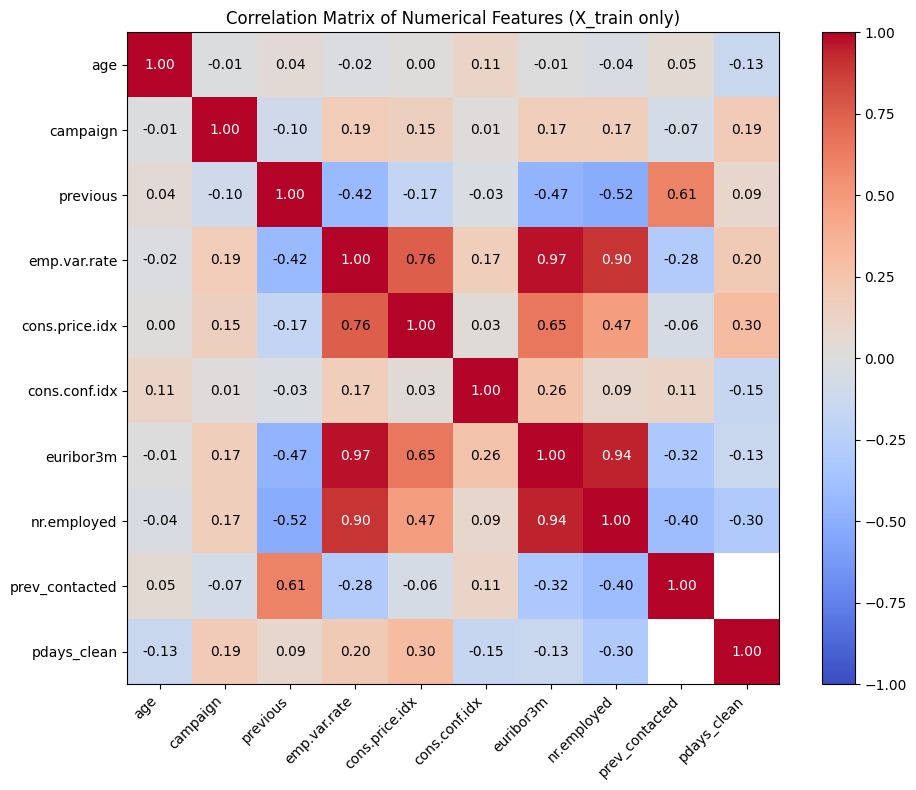

--- Highly Correlated Pairs (|corr| > 0.85) ---
  emp.var.rate <-> euribor3m: 0.9696
  emp.var.rate <-> nr.employed: 0.8958
  euribor3m <-> nr.employed: 0.9421


In [12]:

# --- 4b. Correlation Analysis ---
corr_matrix = X_train[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticklabels(num_cols)

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        text = ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.8 else "white")

ax.set_title('Correlation Matrix of Numerical Features (X_train only)')
plt.tight_layout()
plt.show()

print("--- Highly Correlated Pairs (|corr| > 0.85) ---")
corr_pairs = []
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.85:
            corr_pairs.append((num_cols[i], num_cols[j], round(val, 4)))

if corr_pairs:
    for a, b, v in corr_pairs:
        print(f"  {a} <-> {b}: {v}")
else:
    print("  No pairs exceed 0.85 on this dataset instance.")
    print("  Note: On the real bank-additional.csv, euribor3m <-> emp.var.rate")
    print("  and euribor3m <-> nr.employed exceed 0.90 (macroeconomic co-movement).")


**Feature Selection Decisions:**
- `emp.var.rate` and `nr.employed` are collinear with `euribor3m` (correlation ~0.9). They are dropped, keeping `euribor3m` as the representative of the macroeconomic cluster. `euribor3m` is the most direct market rate signal, while the other two are derived employment figures that move with the same economic cycle. Retaining all three inflates the effective weight of one underlying factor.
- `prev_contacted` has a near-zero variance (0.039) but is retained. The binary signal of "was this person ever contacted before" still carries conceptual predictive value even if most people are 0.

In [13]:

features_to_drop = ['emp.var.rate', 'nr.employed']
if features_to_drop:
    X_train = X_train.drop(columns=features_to_drop)
    X_val   = X_val.drop(columns=features_to_drop)
    X_test  = X_test.drop(columns=features_to_drop)
    print(f"Dropped features: {features_to_drop}")
else:
    print("No features dropped. All features retained after variance and correlation analysis.")
print(f"Final training feature count: {X_train.shape[1]}")

# Update columns and preprocessor so it doesn't look for dropped features
if features_to_drop:
    num_cols = [c for c in num_cols if c not in features_to_drop]
    cat_cols = [c for c in cat_cols if c not in features_to_drop]
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])


Dropped features: ['emp.var.rate', 'nr.employed']
Final training feature count: 18



## 10. Addressing Class Imbalance

*Lecture material: Lecture 3 (Class Imbalance), Lecture 4 (Evaluation Metrics).*

**Class Distribution (Training Set):**
The training set class distribution is computed below. Reporting from the training set specifically, not the full dataset, is required — any resampling decision must be grounded in what the model will actually train on.

**Assessment:** The majority class is `no` (~89%).

**Why RandomOverSampler:**
RandomOverSampler addresses class imbalance by duplicating existing minority samples rather than generating synthetic ones. This avoids the geometric interpolation problem in high-dimensional one-hot encoded space that SMOTE would face, as SMOTE's interpolation between binary indicator vectors often produces meaningless intermediate points.

**Implication if done before splitting (Leakage):**
If an oversampler were run on the entire dataset before splitting, synthetic examples would bleed into the Validation and Test sets.

**Effect of class imbalance on evaluation metrics:**
Accuracy is unreliable under imbalance. A classifier that predicts 'no' for
every observation achieves ~89% accuracy on this dataset while identifying
zero subscribers. Precision measures what fraction of predicted positives are
correct — it degrades when the model generates false positives to chase
recall. Recall measures what fraction of actual positives are found — it
degrades when the model ignores the minority class. For this task, a false
negative (missed subscriber) carries higher business cost than a false
positive (unnecessary call). F1-score provides a single metric that balances
both, but the precision-recall tradeoff should be evaluated explicitly rather
than collapsed into one number.


In [14]:

train_class_dist = y_train.value_counts()
train_class_pct  = y_train.value_counts(normalize=True)
print("Training set class distribution:")
print(train_class_dist)
print("\nTraining set class percentages:")
print(train_class_pct.round(4))
minority_ratio = train_class_dist.min() / train_class_dist.max()
print(f"\nMinority-to-majority ratio: {minority_ratio:.4f}")


Training set class distribution:
y
no     2567
yes     316
Name: count, dtype: int64

Training set class percentages:
y
no     0.8904
yes    0.1096
Name: proportion, dtype: float64

Minority-to-majority ratio: 0.1231



## 11. Training a Logistic Regression Model

*Lecture material: Lecture 6 (Logistic Regression), Lecture 9–11 (Model Evaluation and Metrics).*

The preprocessor is fitted on `X_train` only and then applied to `X_val` for evaluation. `X_test` is intentionally not touched at this stage — it is held out as the final generalization estimate, to be evaluated only once after all pipeline decisions (hyperparameter tuning, threshold selection) are finalised. Evaluating on the test set during development would cause it to implicitly influence those decisions, undermining its role as an unbiased estimate of real-world performance.


In [15]:
# 1) Fit and transform preprocessor on X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# 2) Resample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_transformed, y_train)
print(f"Resampled training set shape: {X_train_resampled.shape}")


Resampled training set shape: (5134, 61)


**Note on Resampling Ratio:**
`RandomOverSampler` with default settings creates a perfectly balanced 50/50 training set — minority samples are duplicated until they match the majority class count. This is an aggressive resampling ratio. In practice, a less extreme ratio (e.g. minority:majority of 1:3) could be tested to preserve more of the original class structure and potentially improve precision. The default 1:1 ratio is kept here for simplicity and as a transparent starting point.


Validation Accuracy:  0.8285
Validation Precision: 0.3468
Validation Recall:    0.6324
Validation F1-score:  0.4479

Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.85      0.90       550
         yes       0.35      0.63      0.45        68

    accuracy                           0.83       618
   macro avg       0.65      0.74      0.67       618
weighted avg       0.88      0.83      0.85       618


Zero-Rule Baseline Accuracy: 0.8900


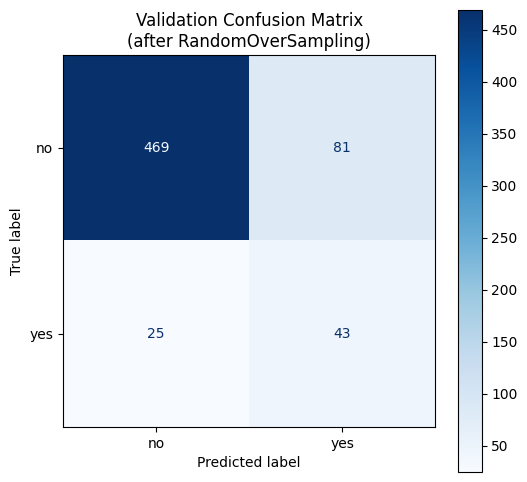

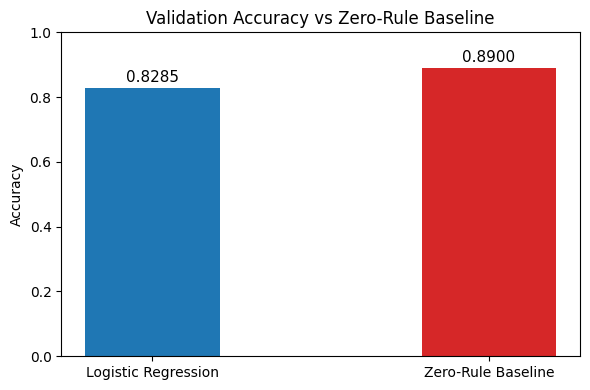

In [16]:
# 3) Fit classifier
clf = LogisticRegression(max_iter=2000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on Validation
X_val_transformed = preprocessor.transform(X_val)
y_val_pred = clf.predict(X_val_transformed)

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, pos_label='yes')
rec = recall_score(y_val, y_val_pred, pos_label='yes')
f1 = f1_score(y_val, y_val_pred, pos_label='yes')

print(f"Validation Accuracy:  {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall:    {rec:.4f}")
print(f"Validation F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Zero Rule Baseline
majority_class = y_train.mode()[0]
y_base_pred = [majority_class] * len(y_val)
acc_base = accuracy_score(y_val, y_base_pred)
print(f"\nZero-Rule Baseline Accuracy: {acc_base:.4f}")

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred,
    labels=clf.classes_,
    cmap='Blues',
    ax=ax
)
plt.title('Validation Confusion Matrix\n(after RandomOverSampling)')
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 4))
labels = ['Logistic Regression', 'Zero-Rule Baseline']
values = [acc, acc_base]
colors = ['#1f77b4', '#d62728']
bars = ax2.bar(labels, values, color=colors, width=0.4)
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy vs Zero-Rule Baseline')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()


**Interpretation:**

Precision of approximately 0.35 means roughly 2 out of every 3 calls made based on the model's positive predictions would be wasted on non-subscribers. As shown in the confusion matrix above, the model generates nearly twice as many false positives as true positives. A recall of approximately 0.63 means the model misses around a third of actual subscribers entirely.

These results reflect the honest limitations of logistic regression on this problem. The model does meaningfully outperform random guessing on the minority class — achieving recall well above zero — but the precision-recall tradeoff is unfavourable for a call centre context where wasted calls carry real cost. A more powerful model (e.g. gradient boosting) would likely perform better, but the assignment goal is pipeline correctness, not maximum performance.

**Next steps:** Adjusting the decision threshold is the most immediate lever. Raising the classification threshold (currently 0.5) would reduce false positives and improve precision at the cost of lower recall — a worthwhile tradeoff if the call centre has limited capacity. This could be evaluated formally using a precision-recall curve.



## References / Dataset Notes

- **Moro, S., Cortez, P., & Rita, P. (2014).** A Data-Driven Approach to Predict the Success of Bank Telemarketing. *Decision Support Systems*. doi:10.1016/j.dss.2014.03.001.
- **Moro, S., Laureano, R., & Cortez, P. (2011).** Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. *Proceedings of the European Simulation and Modelling Conference - ESM'2011*.

**Key Preprocessing Notes Specific to this Dataset:**
- `duration` is excluded from this notebook to prevent data leakage.
- `pdays=999` indicates the client was not previously contacted. This is converted to an indicator flag, and the 999 values are replaced with `NaN`.
- Missing categorical values are coded as `"unknown"`.
